# This notebook studies how new sets of labels appear in time and how frequently they'll reappear in the future

### Import dataset

In [1]:
import pandas as pd

In [2]:
PATH = "../Dataset_preparation_and_inference/Datasets/Cyberlab"
predicted_corpus = pd.read_csv(f"{PATH}/corpus_with_predictions.csv")
predicted_corpus.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...


#### Filter "/system scheduler" sessions --> not bash

In [3]:
print(f"Before filtering '/system scheduler' sessions: {predicted_corpus.shape[0]}")
predicted_corpus = predicted_corpus[~predicted_corpus.full_session.str.contains("/system scheduler")]
print(f"After filtering '/system scheduler' sessions: {predicted_corpus.shape[0]}")

Before filtering '/system scheduler' sessions: 233035
After filtering '/system scheduler' sessions: 232836


#### Create date attribute

In [4]:
predicted_corpus["first_timestamp"] = pd.to_datetime(predicted_corpus["first_timestamp"])
predicted_corpus["date"] = predicted_corpus["first_timestamp"].apply(lambda datetime: datetime.date())
predicted_corpus.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions,date
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04


#### Obtain percentage of Tactics before and after the server update

In [5]:
from datetime import datetime
server_update_date = datetime.strptime("08/11/2019", '%d/%m/%Y').date()
server_update_datetime = datetime.strptime("08/11/2019", '%d/%m/%Y')

print(f"Server update occurred in {server_update_date}")

Server update occurred in 2019-11-08


In [6]:
sessions_date_predictions = predicted_corpus[["full_session", "Models_predictions", "date"]]
sessions_date_predictions["splitted_session"] = sessions_date_predictions["full_session"].apply(lambda session: session.split(" "))
sessions_date_predictions["splitted_prediction"] = sessions_date_predictions["Models_predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = sessions_date_predictions[["splitted_session", "splitted_prediction", "date"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Exploded dataset contains 28148367 rows and 3 columns


,splitted_session,splitted_prediction,date
0,enable,Discovery,2019-06-04
0,;,Discovery,2019-06-04


In [8]:
after_update = exploded_df[exploded_df.date >= server_update_date]
before_update = exploded_df[exploded_df.date < server_update_date]
print(f"{after_update.shape[0]} words after; {before_update.shape[0]} words before")

19309066 words after; 8839301 words before


In [14]:
stats_before = before_update.groupby("splitted_prediction")["splitted_session"].count().reset_index(name = "words_per_class") 
stats_before["percentage"] = stats_before.words_per_class.apply(lambda el: round(el / before_update.shape[0] * 100, 3))
print("Before:")
stats_before

Before:


,splitted_prediction,words_per_class,percentage
0,Defense Evasion,117562,1.330
1,Discovery,6965031,78.796
2,Execution,1038001,11.743
3,Harmless,1618,0.018
4,Impact,54,0.001
5,Other,3730,0.042
6,Persistence,713305,8.070


In [15]:
stats_after = after_update.groupby("splitted_prediction")["splitted_session"].count().reset_index(name = "words_per_class") 
stats_after["percentage"] = stats_after.words_per_class.apply(lambda el: round(el / after_update.shape[0] * 100, 3))
print("After:")
stats_after

After:


,splitted_prediction,words_per_class,percentage
0,Defense Evasion,21212,0.110
1,Discovery,15899342,82.341
2,Execution,731210,3.787
3,Harmless,7334,0.038
4,Impact,185,0.001
5,Other,55,0.000
6,Persistence,2649728,13.723


### How many unique sequences of predicted classes?

In [16]:
counter_model_predictions = predicted_corpus.value_counts("Models_predictions").reset_index().rename({0:"associated_sessions"}, axis = 1)
print(f"Number of unique model's predictions: {counter_model_predictions.shape[0]}")
counter_model_predictions.head(2)

Number of unique model's predictions: 1672


,Models_predictions,associated_sessions
0,Discovery -- Discovery -- Discovery -- Discove...,115543
1,Discovery -- Discovery -- Discovery -- Discove...,30644


### Obtain ECDF

In [17]:
import numpy as np
counter_model_predictions = counter_model_predictions.sort_values(by = ["associated_sessions"])
cdf_models_predictions = counter_model_predictions.value_counts("associated_sessions").sort_index()
cdf_models_predictions = np.cumsum(cdf_models_predictions)/np.sum(cdf_models_predictions)
cdf_models_predictions = cdf_models_predictions.reset_index(name = "cdf")
cdf_models_predictions.head(2)

,associated_sessions,cdf
0,1,0.57177
1,2,0.69677


In [18]:
threshold_sessions = cdf_models_predictions[cdf_models_predictions.cdf >= .9].iloc[0]["associated_sessions"]

#### Now obtain inverse information: on the x_axis I the session ID; on the y_axis, the number of other sessions with the same prediction as the one I am considering

In [19]:
predicted_corpus = predicted_corpus.merge(counter_model_predictions, on = "Models_predictions").sort_values(by = "associated_sessions")
predicted_corpus.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions,date,associated_sessions
232835,232941,cat /proc/cpuinfo | grep name | wc -l ; echo -...,prod-ubuntu-ssh-k8s-local-1,2020-02-29 20:50:19.338933+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2020-02-29,1
224065,100611,LC_ALL=C cat /etc/rc.local /etc/rc.d/rc.local ...,ubuntu_basic_pool,2019-11-24 20:50:40.329803+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-11-24,1


In [20]:
counter_sessions_per_family = predicted_corpus.groupby("associated_sessions")["full_session"].count().reset_index().rename({"associated_sessions": "|sessions in the same family|", "full_session":"occurrences"}, axis = 1)
counter_sessions_per_family.tail(2)

,|sessions in the same family|,occurrences
99,30644,30644
100,115543,115543


In [21]:
counter_sessions_per_family["cdf_occurrences"] = 1 - np.cumsum(counter_sessions_per_family["occurrences"])/np.sum(counter_sessions_per_family["occurrences"])
print(counter_sessions_per_family.shape[0])
counter_sessions_per_family.head(2)

101


,|sessions in the same family|,occurrences,cdf_occurrences
0,1,956,0.995894
1,2,418,0.994099


In [22]:
threshold_sessions

11.0

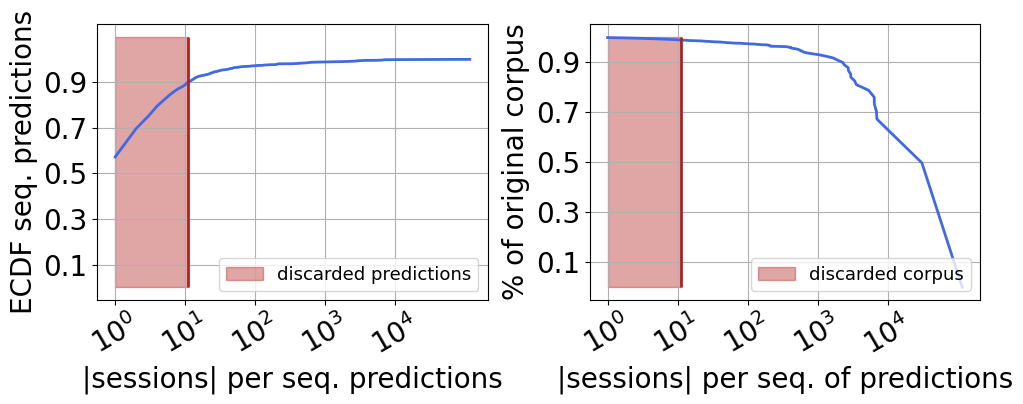

In [23]:
import matplotlib.pyplot as plt 

fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(10,4))
fontsize = 20
ax_1.plot(cdf_models_predictions.associated_sessions, cdf_models_predictions.cdf, linewidth = 2, color = "royalblue")
ax_1.vlines(threshold_sessions, 0, 1.1, color = "firebrick", linewidth = 2)
ax_1.fill_between(cdf_models_predictions.associated_sessions, 0, 1.1, where = cdf_models_predictions.associated_sessions <= threshold_sessions, color = "firebrick", alpha = .4, label = "discarded predictions")

ax_1.set_xlabel('|sessions| per seq. predictions', fontsize = fontsize)
ax_1.set_xscale("log")
ax_1.set_ylabel('ECDF seq. predictions', fontsize = fontsize)
ax_1.yaxis.set_tick_params(labelsize=fontsize)
ax_1.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
ax_1.set_xticks([1, 10, 100, 1000, 10000])
ax_1.set_yticks(np.arange(.1, 1.1, .2))
ax_1.legend(fontsize = fontsize - 7, loc = "lower right")
ax_1.grid()

ax_2.plot(counter_sessions_per_family["|sessions in the same family|"], counter_sessions_per_family["cdf_occurrences"], linewidth = 2, color = "royalblue")
ax_2.vlines(threshold_sessions, 0, 1., color = "firebrick", linewidth = 2)
ax_2.fill_between(counter_sessions_per_family["|sessions in the same family|"], 0, 1., where = counter_sessions_per_family["|sessions in the same family|"] <= threshold_sessions, color = "firebrick", alpha = .4, label = "discarded corpus")

ax_2.set_xlabel('|sessions| per seq. of predictions', fontsize = fontsize)
ax_2.set_xscale("log")
ax_2.set_ylabel('% of original corpus', fontsize = fontsize)
ax_2.yaxis.set_tick_params(labelsize=fontsize)
ax_2.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
ax_2.set_xticks([1, 10, 100, 1000, 10000])
ax_2.set_yticks(np.arange(.1, 1.1, .2))
ax_2.legend(fontsize = fontsize - 7, loc = "lower right")

ax_2.grid()
plt.tight_layout()
plt.show()

#### Focus on the 10% labels with most associated sessions (>10)

In [24]:
most_common_labels = counter_model_predictions[counter_model_predictions.associated_sessions >= threshold_sessions]
print(f"We selected {most_common_labels.shape[0]} labels (which covers {(most_common_labels.shape[0]/counter_model_predictions.shape[0]) * 100:.2f} % of the total)")
most_common_labels.head(2)

We selected 186 labels (which covers 11.12 % of the total)


,Models_predictions,associated_sessions
173,Discovery -- Discovery -- Discovery -- Discove...,11
172,Discovery -- Discovery -- Discovery -- Discove...,11


In [25]:
print(f"Those {most_common_labels.shape[0]} labels also covers {most_common_labels.associated_sessions.sum()} of the sessions ({most_common_labels.associated_sessions.sum() / predicted_corpus.shape[0] * 100:.2f} % of the total)")

Those 186 labels also covers 229835 of the sessions (98.71 % of the total)


#### Visualize them in the time-series of points

##### For each label, save first date in which we've seen that label

In [26]:
predicted_corpus.sort_values(by = "first_timestamp", inplace = True)
first_appearance_per_prediction = predicted_corpus.groupby("Models_predictions")["date"].agg("first").reset_index()
first_appearance_per_prediction.sort_values(by = "date", ascending = True, inplace = True)
first_appearance_per_prediction.head(2)

,Models_predictions,date
1499,Execution -- Execution -- Execution -- Executi...,2019-06-04
67,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04


##### Now, trick to easily count labels occurrences

In [16]:
predictions_per_day = predicted_corpus.groupby("date")["Models_predictions"].agg(list).reset_index().rename({"Models_predictions":"Predictions_per_day"}, axis = 1)
predictions_per_day["Predictions_per_day"] = predictions_per_day["Predictions_per_day"].apply(lambda list_predictions: " __ ".join(list_predictions))
predictions_per_day.head(2)

,date,Predictions_per_day
0,2019-06-04,Discovery -- Discovery -- Discovery -- Discove...
1,2019-06-05,Discovery -- Discovery -- Discovery -- Discove...


##### Doing that, each row will contain dates. Each column will be associated to a prediction

In [17]:
def custom_tokenizer(session):
    return [el.strip() for el in session.split(" __ ")]

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, lowercase = False, binary = True)
X = vectorizer.fit_transform(predictions_per_day.Predictions_per_day).toarray()
names = vectorizer.get_feature_names_out()
df_count_vectorizer = pd.DataFrame(X, columns=names, index = predictions_per_day.date)
print(f"Dataframe has shape {df_count_vectorizer.shape[0]} x {df_count_vectorizer.shape[1]}")
#df_count_vectorizer.set_index([pd.Index(predictions_per_day.date.values)])

Dataframe has shape 256 x 1672


##### Eventually, prepare colors
- "selected sessions" (>= 10 occurrences) in green
- "other sessions" (< 10 occurrences) in black and smaller

In [19]:
first_appearance_per_prediction["is_numerous"] = first_appearance_per_prediction["Models_predictions"].apply(lambda prediction: 1 if prediction in most_common_labels.Models_predictions.values else 0)
first_appearance_per_prediction.head(2)

,Models_predictions,date,is_numerous
1499,Execution -- Execution -- Execution -- Executi...,2019-06-04,1
67,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04,1


##### Define colors

In [20]:
colors = {
    1: {"color":"forestgreen", "size": 20},
    0: {"color":"black", "size": 10}
}

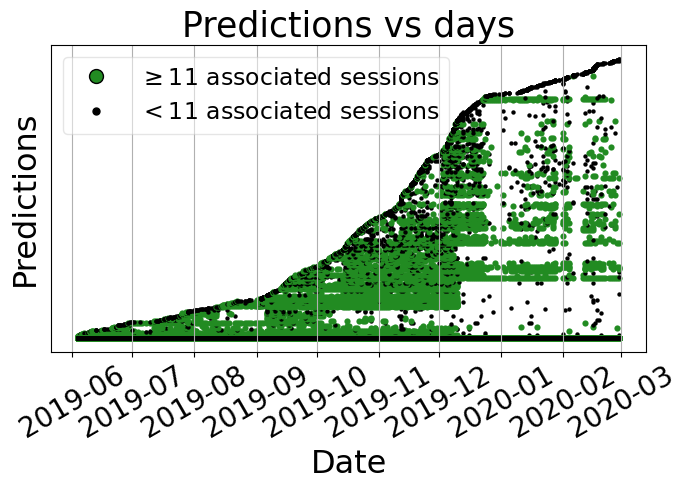

In [21]:
import matplotlib as mpl
from matplotlib.lines import Line2D
fig, axs = plt.subplots(1, figsize=(7,5))
fontsize = 20
df_count_vectorizer = df_count_vectorizer.reindex(sorted(df_count_vectorizer.columns), axis=1)
n_days = df_count_vectorizer.shape[0]
y_values = []
for it in range(first_appearance_per_prediction.shape[0]): # Rows are sorted by ascending date
    prediction = first_appearance_per_prediction.iloc[it].Models_predictions
    is_numerous = first_appearance_per_prediction.iloc[it].is_numerous
    x_coord = df_count_vectorizer.index.values # dates
    y_coord = (it +1) * df_count_vectorizer[prediction].values # present/non present according to prediction under analysis (each gets a new row)
    c = colors[is_numerous]["color"]
    s = colors[is_numerous]["size"]
    scatters = axs.scatter(x_coord, y_coord, s = s, color = c, alpha = 1, linewidth = 0, edgecolors="k")
    if is_numerous == 1:
        y_values.append(it +1)

axs.set_title(f'Predictions vs days', fontsize = fontsize + 5)
axs.set_ylabel('Predictions', fontsize = fontsize + 3)
axs.set_xlabel('Date', fontsize = fontsize + 3)
axs.yaxis.set_ticks([])
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)  

point_major = Line2D([0], [0], label=f"$\geq{int(threshold_sessions)}$ associated sessions", markersize=20, markerfacecolor='forestgreen', linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
point_minor = Line2D([0], [0], label= f"$<{int(threshold_sessions)}$ associated sessions", markersize=10, markerfacecolor='k', linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
# add manual symbols to auto legend
plt.legend(handles=[point_major, point_minor], fontsize = fontsize - 3, loc = "upper left", framealpha=0.5)
axs.grid()
plt.tight_layout()
plt.show()

### Another visualization

#### Define colors

In [23]:
import seaborn as sns
import math 
from matplotlib.colors import ListedColormap
colors = sns.color_palette("rocket_r", round(math.log(counter_model_predictions.associated_sessions.max()) + 1))
print(f"Created {len(list(colors))} colors")
cmap = ListedColormap(colors)   

Created 13 colors


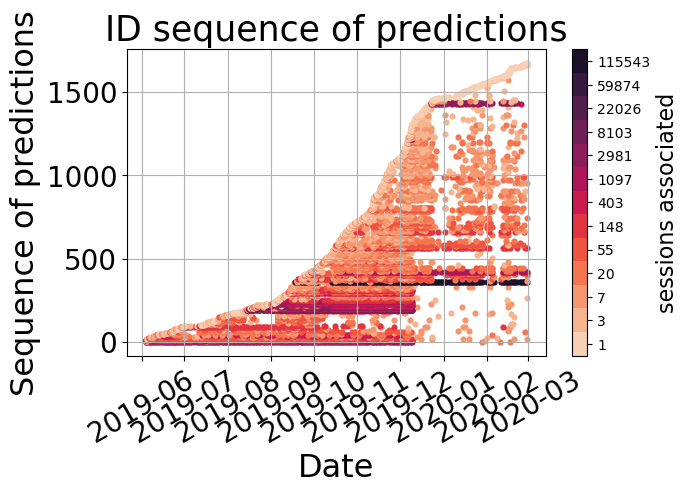

In [30]:
import matplotlib as mpl
fig, axs = plt.subplots(1, figsize=(7,5))
fontsize = 20
n_days = df_count_vectorizer.shape[0]

for it, column in enumerate(first_appearance_per_prediction.Models_predictions):
    x_coord = df_count_vectorizer.index.values
    y_coord = (it +1) * df_count_vectorizer[column].values.astype('float')
    y_coord[y_coord == 0] = 'nan'
    c = colors[round(math.log(counter_model_predictions[counter_model_predictions.Models_predictions == column]["associated_sessions"].iloc[0]))]
    scatters = axs.scatter(x_coord, y_coord, s = 20, color = c, alpha = 1, linewidth = 0, edgecolors="k")

axs.set_title('ID sequence of predictions', fontsize = fontsize + 5)
axs.set_ylabel('Sequence of predictions', fontsize = fontsize + 3)
axs.set_xlabel('Date', fontsize = fontsize + 3)
#axs.yaxis.set_ticks([])
axs.yaxis.set_tick_params(labelsize=fontsize)  
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)  

# creating ScalarMappable
norm = mpl.colors.Normalize(vmin=0, vmax=round(math.log(counter_model_predictions.associated_sessions.max()) + 1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
  
cbar = plt.colorbar(sm, orientation='vertical', ticks=np.arange(.5, len(colors) +.5))
cbar.set_label(label='sessions associated',fontsize=fontsize - 4)
cbar.ax.set_yticklabels([round(math.e ** el) for el in range(0, len(colors) -1)] + [counter_model_predictions.associated_sessions.max()]) # Last, add real maximum
axs.grid()

plt.tight_layout()
plt.show()

#### Another visualization:

In [31]:
df_associated_sessions_per_date = predicted_corpus.groupby(["Models_predictions", "date"])["full_session"].count().reset_index(name = "associated_sessions")
df_associated_sessions_per_date = df_associated_sessions_per_date.sort_values(by = "date")
df_associated_sessions_per_date.head(2)

,Models_predictions,date,associated_sessions
9267,Execution -- Execution -- Execution -- Executi...,2019-06-04,1
195,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04,2


In [32]:
birth_and_occurrences = first_appearance_per_prediction.merge(counter_model_predictions, on = "Models_predictions")
print("Displaying examples in the order of date of birth:")
birth_and_occurrences.sort_values(by = "date").head(5)

Displaying examples in the order of date of birth:


,Models_predictions,date,is_numerous,associated_sessions
0,Execution -- Execution -- Execution -- Executi...,2019-06-04,1,14
11,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04,1,2957
9,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04,1,799
8,Execution -- Execution -- Execution -- Executi...,2019-06-04,0,8
7,Execution -- Execution -- Execution -- Executi...,2019-06-04,0,2


In [33]:
ids_predictions = birth_and_occurrences.sort_values(by = "date")[["Models_predictions"]].reset_index(drop = True).reset_index().rename({"index": "Prediction_id"}, axis = 1)
ids_predictions.head(2)

,Prediction_id,Models_predictions
0,0,Execution -- Execution -- Execution -- Executi...
1,1,Discovery -- Discovery -- Discovery -- Discove...


In [34]:
df_associated_sessions_per_date = df_associated_sessions_per_date.merge(ids_predictions, on = "Models_predictions")
df_associated_sessions_per_date = df_associated_sessions_per_date[df_associated_sessions_per_date.Prediction_id != df_associated_sessions_per_date.Prediction_id.max()]
df_associated_sessions_per_date.head(2)

,Models_predictions,date,associated_sessions,Prediction_id
0,Execution -- Execution -- Execution -- Executi...,2019-06-04,1,5
1,Execution -- Execution -- Execution -- Executi...,2019-06-05,1,5


In [109]:
filtered = df_associated_sessions_per_date[df_associated_sessions_per_date.associated_sessions > 1]

#### Visualization

In [36]:
from datetime import datetime
server_update_date = datetime.strptime("08/11/2019", '%d/%m/%Y').date()
server_update_datetime = datetime.strptime("08/11/2019", '%d/%m/%Y')

print(f"Server update occurred in {server_update_date}")

Server update occurred in 2019-11-08


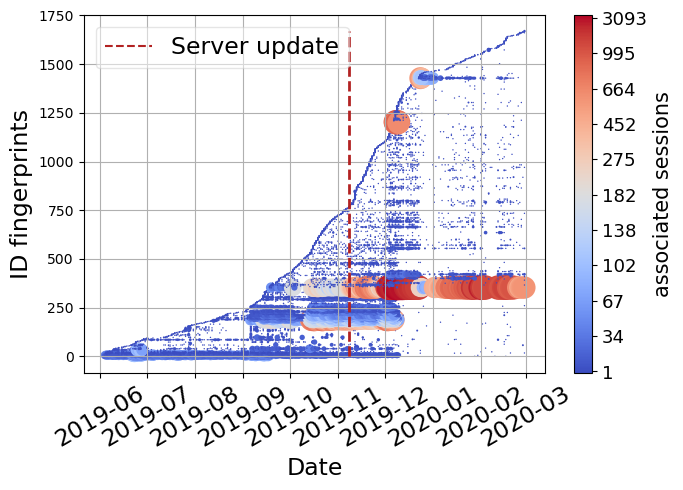

In [116]:
fig, axs = plt.subplots(figsize =(7, 5))
fontsize = 15
unique_associated_sessions = df_associated_sessions_per_date.sort_values(by = "associated_sessions").drop_duplicates("associated_sessions")["associated_sessions"]
sizes = {key:value for key, value in zip(unique_associated_sessions, np.arange(1, 1*unique_associated_sessions.shape[0] + 1, 1))}
palette = sns.color_palette("coolwarm", len(sizes))
cmap = sns.color_palette("coolwarm", len(sizes), as_cmap=True)
sns.scatterplot(df_associated_sessions_per_date, palette = palette, x = "date", y = "Prediction_id", hue = "associated_sessions", size = "associated_sessions", sizes = sizes, ax = axs, legend = None, edgecolor="black", linewidth=0)
axs.vlines(server_update_datetime, 0, df_associated_sessions_per_date.Prediction_id.max(), label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
#axs.set_yticks([])

server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
handles = [server_update]
#index_of_interest = [0, round(len(sizes.keys()) / 2), -1]
#for index, marker_size in zip(index_of_interest, [5, 20, 25]):
#    size = sizes[list(sizes.keys())[index]]
#    color = palette[index]
#    handles.append(Line2D([0], [0], label=f"{size} sessions associated", markersize=marker_size, markerfacecolor=color, linewidth = .2, markeredgecolor="k", marker='.', linestyle=''))
# add manual symbols to auto legend
axs.legend(handles=handles, fontsize = fontsize +2, loc = "upper left", framealpha=0.5)
#axs.set_xticklabels(x_labels)

# creating ScalarMappable
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(list(sizes.values())))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
  
#ticks = np.arange(.5, len(list(sizes.values())) + .5)
step = round(len(list(sizes.values())) / 10)    
cbar = plt.colorbar(sm, orientation='vertical', ticks=np.arange(1, len(list(sizes.values())), step))
cbar.set_label(label='associated sessions',fontsize=fontsize)
cbar.ax.set_yticklabels(list(sizes.keys())[::step], fontsize = fontsize - 2) # Last, add real maximum
axs.grid()
axs.tick_params(axis='x', rotation=30, labelsize = fontsize+2)
axs.set_ylabel("ID fingerprints", fontsize = fontsize + 2)
axs.set_xlabel("Date", fontsize = fontsize + 2)
plt.tight_layout()
plt.savefig("./Inference_results/4_Forensic/seq_in_time.pdf")

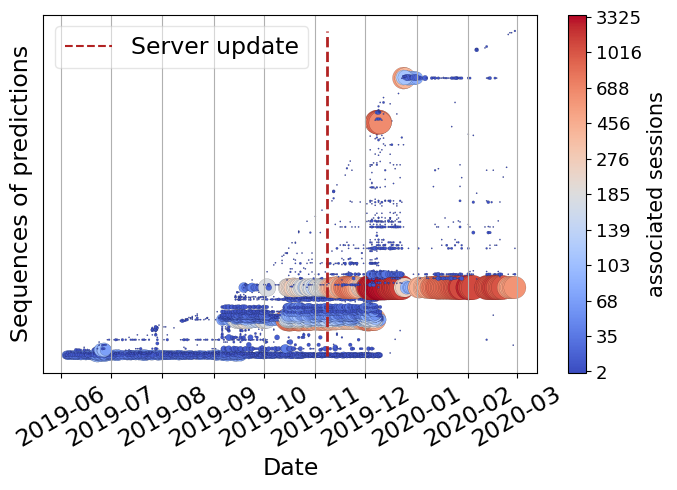

In [110]:
fig, axs = plt.subplots(figsize =(7, 5))
fontsize = 15
unique_associated_sessions = filtered.sort_values(by = "associated_sessions").drop_duplicates("associated_sessions")["associated_sessions"]
sizes = {key:value for key, value in zip(unique_associated_sessions, np.arange(1, 1*unique_associated_sessions.shape[0] + 1, 1))}
palette = sns.color_palette("coolwarm", len(sizes))
cmap = sns.color_palette("coolwarm", len(sizes), as_cmap=True)
sns.scatterplot(filtered, palette = palette, x = "date", y = "Prediction_id", hue = "associated_sessions", size = "associated_sessions", sizes = sizes, ax = axs, legend = None, edgecolor="black")
axs.vlines(server_update_datetime, 0, filtered.Prediction_id.max(), label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs.set_yticks([])

server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
handles = [server_update]
#index_of_interest = [0, round(len(sizes.keys()) / 2), -1]
#for index, marker_size in zip(index_of_interest, [5, 20, 25]):
#    size = sizes[list(sizes.keys())[index]]
#    color = palette[index]
#    handles.append(Line2D([0], [0], label=f"{size} sessions associated", markersize=marker_size, markerfacecolor=color, linewidth = .2, markeredgecolor="k", marker='.', linestyle=''))
# add manual symbols to auto legend
axs.legend(handles=handles, fontsize = fontsize +2, loc = "upper left", framealpha=0.5)
#axs.set_xticklabels(x_labels)

# creating ScalarMappable
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(list(sizes.values())))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
  
#ticks = np.arange(.5, len(list(sizes.values())) + .5)
step = round(len(list(sizes.values())) / 10)    
cbar = plt.colorbar(sm, orientation='vertical', ticks=np.arange(1, len(list(sizes.values())), step))
cbar.set_label(label='associated sessions',fontsize=fontsize)
cbar.ax.set_yticklabels(list(sizes.keys())[::step], fontsize = fontsize - 2) # Last, add real maximum
axs.grid()
axs.tick_params(axis='x', rotation=30, labelsize = fontsize+2)
axs.set_ylabel("Sequences of predictions", fontsize = fontsize + 2)
axs.set_xlabel("Date", fontsize = fontsize + 2)
plt.tight_layout()
plt.savefig("./Inference_results/4_Forensic/seq_in_time.pdf")